Date: 3/21/2023<br>
Author: Amparo Godoy Pastore

# Introduction

*E. coli* bacteria exhibit a particular motion pattern called "run-and-tumble", alternating straight "runs" at a constant speed and brief "tumbles" where they randomly select a new direcction. Although this may initially appear as a haphazard movement that lacks any control or direction towards food sources, it is in fact a viable foraging strategy that statistically directs bacteria towards food.

The purpose of this project is to model run-and-tumble motion and food-depending tumbling to show that it is an effective foraging tactic. The relevance of this study lies in the insights it can provide into how bacterial populations explore and exploit their environment, which could have important implications in fields such as microbiology, ecology, and biotechnology.  


# Preliminaries

In [1]:
import numpy as np
from numpy.random import rand
from numpy.random import seed
import matplotlib.pyplot as plt
import time
from numpy.linalg import norm

## Visualization

We will be using the function `animate_trajectory` bellow, to animate the trajectory of the bacterium and better study the effectiveness of "run-and-tumble".

In [2]:
def animate_trajectory(pos, interval=0, lw=0.5, ms=20):
    '''Create animated figure showing the bacterium's motion.
    Arguments:
    pos:      Nx2 array containing the 2 position coordinates (x and y) at each of the N time steps.
    interval: Waiting time between frames of the animation, in seconds. '''
    # Close all active plots.
    plt.close('all')
    # Turn on interactive mode.
    %matplotlib notebook
    # Create a new plot.
    fig,ax = plt.subplots()
    # Make sure one inch along x represents the same length as one inch along y.
    x1,x2 = np.min(pos[:,0]),np.max(pos[:,0])
    y1,y2 = np.min(pos[:,1]),np.max(pos[:,1])
    dx,dy = x2-x1,y2-y1
    ax.set_xlim(x1-0.1*dx,x2+0.1*dx)
    ax.set_ylim(y1-0.1*dy,y2+0.1*dy)
    ax.set_aspect('equal')
    p1 = ax.scatter([], [], color='r', s=ms)
    p2, = ax.plot([], [], color='C0', lw=lw)
    for i in range(pos.shape[0]):
        p1.set_offsets([pos[i]])
        p2.set_data(*pos[:i].T)
        fig.canvas.draw()
        time.sleep(interval)
    plt.close()
    # Turn off interactive mode.
    %matplotlib inline

# Basic run-and-tumble

First, we simulate basic run-and-tumble motion. For this purpose we'll use Euler integration, and check for tumbles at every time step $dt$ by generting a random event with probability $a*dt$. For now, we keep $a$ constant.

<div class="alert alert-block alert-danger">
<b>Task 1:</b>
</div>

Text(0.5, 1.0, 'Figure 1. "Trajectory of basic run-and-tumble motion"')

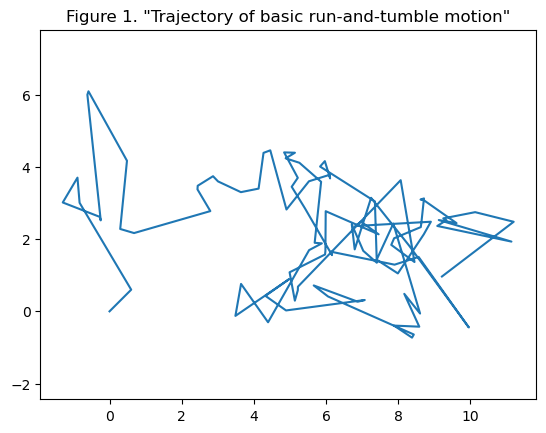

In [3]:
# Initial conditions  
v = 1 # Velocity
a = 1 # Probability
theta = 0 # Angle between v vector and x-axis
t0, t1, dt = 0, 100, 0.1 # Start/end time, time step
r0 = np.array([0, 0]) # Origin
R, T = [r0], [t0] # Keep record of the positions and time steps 

# Euler integration
n = int((t1-t0)/dt)
for i in range(n):
    r, t = R[-1], T[-1]
    # tumble
    if rand() < a*dt:
        #update theta
        theta = 2*np.pi*rand() 
        v = np.array([np.cos(theta), np.sin(theta)])
    dr = dt*v
    r, t = (r + dr), (t + dt)
    R.append(r)
    T.append(t)

R = np.array(R)

# Now we plot a and b as a function of time as well
plt.plot(R[:,0], R[:,1])
plt.axis('equal')
plt.title('Figure 1. "Trajectory of basic run-and-tumble motion"')

<IPython.core.display.Javascript object>


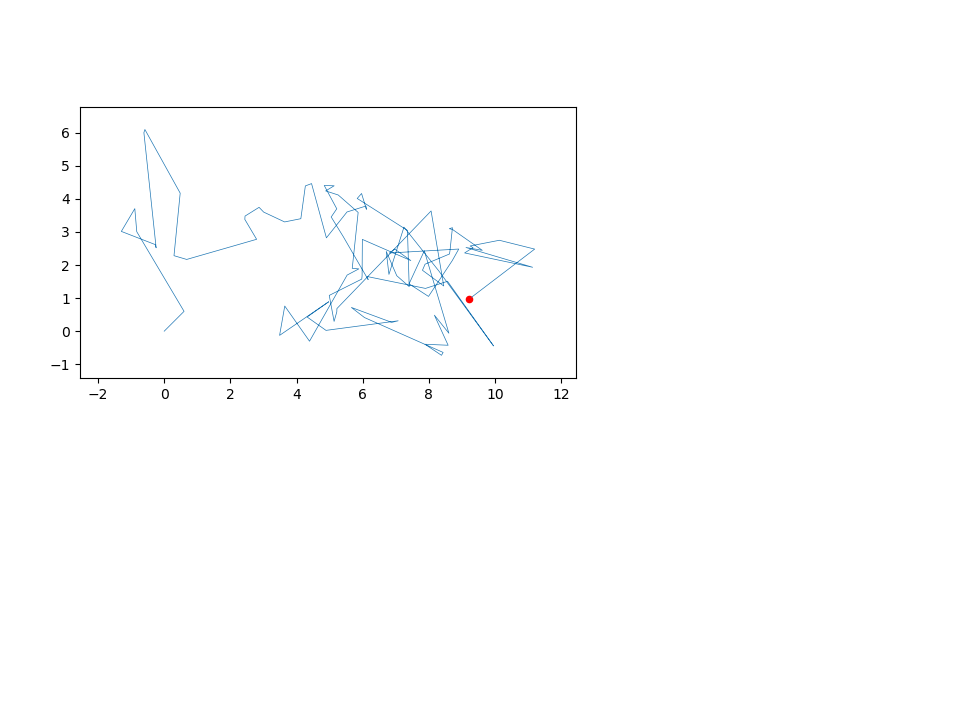

C:\Users\ampig\AppData\Local\Temp\ipykernel_25380\2743308075.py:26: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


In [4]:
# Simulate the motion
animate_trajectory(R, interval=0, lw=0.5, ms=20)

_Figure 1_ shows the trajectory of a bacterium using simple run-and-tumble motion, followed by an animation of the same trajectory. The bacterium is modeled as a point moving at a constant speed $v$. Besides the instantaneous tumbles, the bacterium moves in a straight line, picking a new direction at random and immediately going back to moving at a constant speed $v$ in the new direction. The model above clearly shows the randomness of the tumbles.

# Run-and-tumble chemotaxis


### Food distribution
In this section, we will be focusing on, and modeling, a food-dependent tumbling rate. We first define a function that calculates the food concentration at any given location. As shown in _Figure 2_ below, if the food is placed at the origin the concentration will decrease the further you get from the food source. 

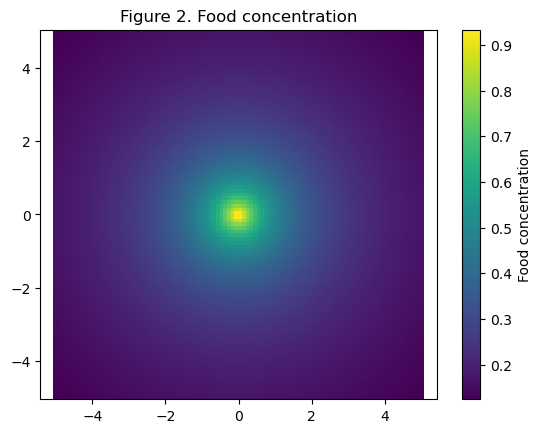

In [5]:
# Function that gives the concentration of food at any point.
# In this case it decreases linearly from the origin.
def food(x,y):
    return 1/(1+norm([x,y], axis=0))

# Plot a colormap of food concentration.
X,Y = np.meshgrid(np.linspace(-5,5,100),np.linspace(-5,5,100))
Z   = food(X,Y)
plt.pcolor(X,Y,Z)
plt.colorbar(label='Food concentration')
plt.axis('equal')
plt.title('Figure 2. Food concentration')
plt.show()

### Implementation

At each step, before performing the tumble check, compute the food concentration at last position and at the current position. If the latter is larger than the former, set the tumbling rate to $\alpha=2$. If it's smaller, set the tumbling rate to $\alpha=0.5$. Then, perform the usual tumble check.

### Food-dependent tumbling rate
We'll now have two tumbling rates $\alpha$: a smaller one when the food concentration is increasing along the bacterium's path, and a larger one when it's decreasing. To implement the food-dependent tumbling rate, we'll compute the food concentration at each step and assign the corresponding tumbling rate, so that if the food concentration around the bacterium is increasing, it will tumble less.

<div class="alert alert-block alert-danger">
<b>Task 2:</b>
</div>

Text(0.5, 1.0, 'Figure 3. Trajectory of food-dependent tumbling motion')

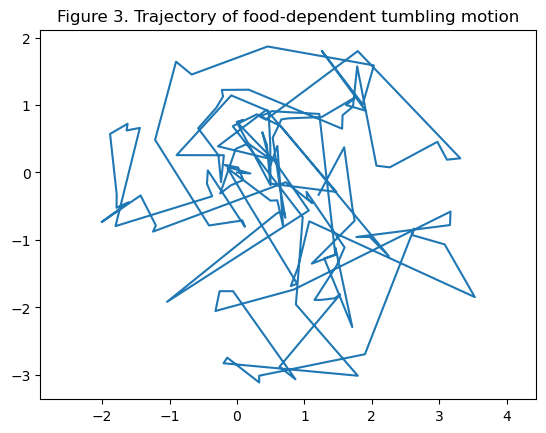

In [49]:
# Initial conditions  
v = 1 # Velocity
theta = 0 # Angle between v vector and x-axis
t0, t1, dt = 0, 100, 0.1 # Start/end time, time step
r0 = np.array([0, 0]) # Origin
R, T = [r0], [t0] # Keep record of the positions and time steps 

# Euler integration
n = int((t1-t0)/dt)
for i in range(n):
    r, t = R[-1], T[-1]
    # Compare food concentration
    if (len(R) > 1) and (food(R[i][0], R[i][1]) > food(R[i - 1][0], R[i - 1][1])):
        a = .5
    else:
        a = 2
    # Tumble check
    if rand() < a*dt:
        # Update theta
        theta = 2*np.pi*rand() 
        v = np.array([np.cos(theta), np.sin(theta)])
    dr = dt*v
    r, t = (r + dr), (t + dt)
    R.append(r)
    T.append(t)

R = np.array(R)

# Now we plot a and b as a function of time as well
plt.plot(R[:,0], R[:,1])
plt.axis('equal')
plt.title('Figure 3. Trajectory of food-dependent tumbling motion')

## Validation

Shown above in _Figure 3_ is the resulting trajectory of a bacterium's food-dependent tumbling motion. To determine whether this helps the bacterium locate food, we will plot a density heatmap and compare the bacterium's behavior with and without the switchable tumbling rate.

We encapsulate the bacterial simulation in a function and simulate their dynamics for 1000 time units, with the origin set at [10,0]. We will perform the analysis on the bacteria with and without the switchable rate by comparing 2 different plots: <br>
a) a plot showing the 10 bacteria trajectories in different colors, <br>
b) a 2D histogram of the bacteria's positions

<div class="alert alert-block alert-danger">
<b>Task 3:</b>
</div>

In [37]:
# Encapsulate bacterial simulation in a function
def bacterial(switchable_rate):
    # Initial conditions
    t0, t1, dt, v = 0, 100, .1, 1
    r0 = np.array([10, 0])
    R, T = [r0], [t0]

    # Euler integration
    n = int((t1-t0)/dt)
    for i in range(n):
        r, t = R[-1], T[-1]
        
        # Compare food concentration
        if switchable_rate:
            if (len(R) > 1) and (food(R[i][0], R[i][1]) > food(R[i - 1][0], R[i - 1][1])):
                a = .5
            else:
                a = 2
        else: 
            a = 1
            
        # Tumble check
        if rand() < a*dt:
            # Update theta
            theta = 2*np.pi*rand() 
            v = np.array([np.cos(theta), np.sin(theta)]) # Update v
        dr = dt*v
        r, t = (r + dr), (t + dt)
        R.append(r)
        T.append(t)
        
    R = np.array(R)
    
    return R

Fraction of time spent near origin for switchable rate True: 0.7955044955044955


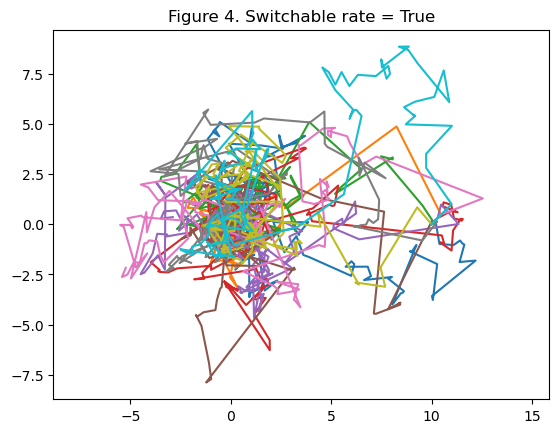

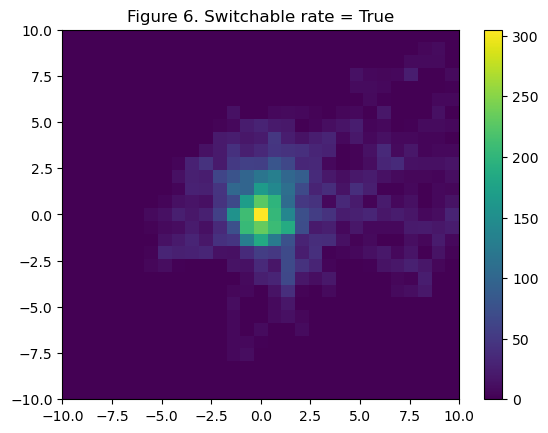

Fraction of time spent near origin for switchable rate False: 0.13346653346653348


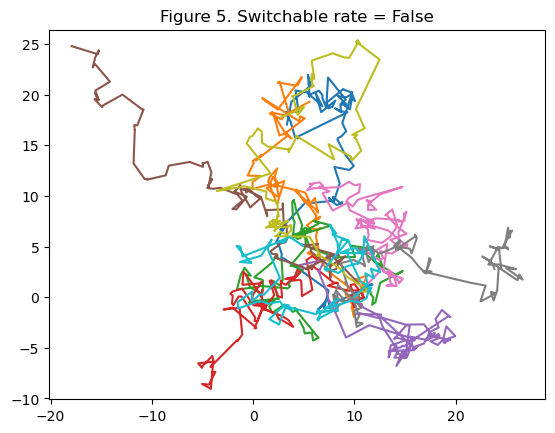

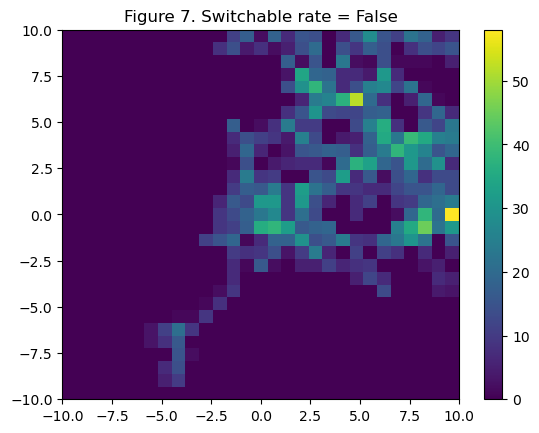

(10, 1001, 2)


In [50]:
# Simulate for 10 bacteria and plot the results of the simulation
bins = np.linspace(-10,10,30) # Restrict  the density map to a sqaure patch [-10,10]x[-10,10]

# Variable num is later used to give number the graphs.
for num, switchable_rate in enumerate([True, False]):
    # Simulate and record
    trajectories = []
    distances = []
    for i in range(10):
        trajectories.append(bacterial(switchable_rate)) # Simulate                  
    trajectories = np.array(trajectories)
    
    # Compute time spent < 5 unit times away from food source
    time_frac = norm(trajectories, axis = 2)
    result = np.sum(time_frac < 5)/(len(time_frac.flatten()))
    print(f'Fraction of time spent near origin for switchable rate {switchable_rate}: {result}')

    # Plot
    for i in range(len(trajectories)):
        plot = plt.plot(trajectories[i][:,0], trajectories[i][:,1])
    plt.axis('equal')
    plt.title(f'Figure {num + 4}. Switchable rate = {switchable_rate}')
    plt.show()
    
    histogram = plt.hist2d(trajectories[:,:,0].flatten(), trajectories[:,:,1].flatten(), bins=bins)
    plt.title(f'Figure {num + 6}. Switchable rate = {switchable_rate}')
    plt.colorbar()
    plt.show()

### Plot of trajectories

_Figure 4_ and _Figure 5_ show the trajectories of 10 bacteria with and without a switchable rate, respectively. We can see that, as expected, the first one is concentrated at the origin, while the second is a lot more spread out horizontally. 

### Histogram of density

_Figure 6_ and _Figure 7_ show the density of the points indicating the location of the bacteria, with and without a switchable rate, respectively. Once again, the concentration in the first one increases around the food source, whereas in _Figure 2_ it is significantly more spread out across the map. 

### Another metric...
Finally, we computed the fraction of the time the bacteria spent less than 5 distance units from the food source (the origin). This metric shows the effectiveness of the bacteria in finding and staying near the food source with the switchable rate. The fraction of time the bacteria spent less than 5 distance units from the food source is $\approx0.796$ for switchable rate True and $\approx0.133$ for switchable rate False. A higher fraction indicates that the bacteria were able to locate and remain close to the food source for a larger portion of the time, suggesting that food-dependent, run-and-tumble motion is a more successful foraging strategy.

# Conclusion

To conclude, we successfully simulated the run-and-tumble motion of bacteria with and without a food-dependent switchable rate, and visualized its trajectory. The resulting trajectory showed an erratic movement with random tumbles, which are characteristic of the bacteria's motion. As we have proved, this seemingly disorganized movement pattern can actually be an effective foraging strategy, as it statistically directs the bacteria towards food sources. All in all, we've effectively achieved our project's objective of proving the efficiency of food-dependent tumbling as a foraging tactic.